In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
import seaborn as sns

conn = sqlite3.connect('transfermarkt.db')

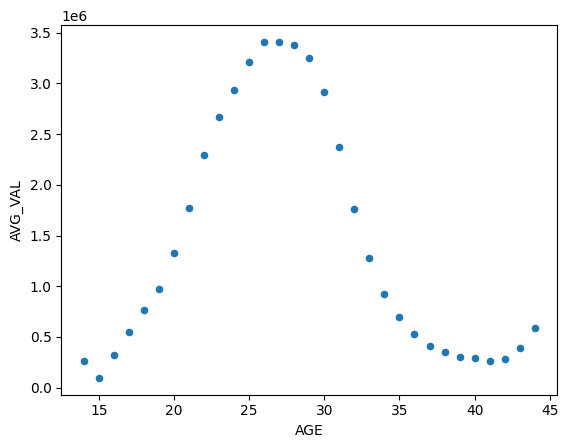

In [10]:
# SQL: Find average player valuation vs player age
query = """
SELECT pv.DATE-p.DATE_OF_BIRTH AS AGE
    ,ROUND(AVG(pv.market_value_in_eur),2) AS AVG_VAL
FROM PLAYERS p
INNER JOIN PLAYER_VALUATIONS pv
ON p.PLAYER_ID = pv.PLAYER_ID
WHERE p.DATE_OF_BIRTH IS NOT NULL
GROUP BY pv.DATE-p.DATE_OF_BIRTH
ORDER BY pv.DATE-p.DATE_OF_BIRTH 
;
"""

df1 = pd.read_sql(query, conn)
df1.head(50)
ax1 = df1.plot.scatter(x='AGE',
                      y='AVG_VAL',
)

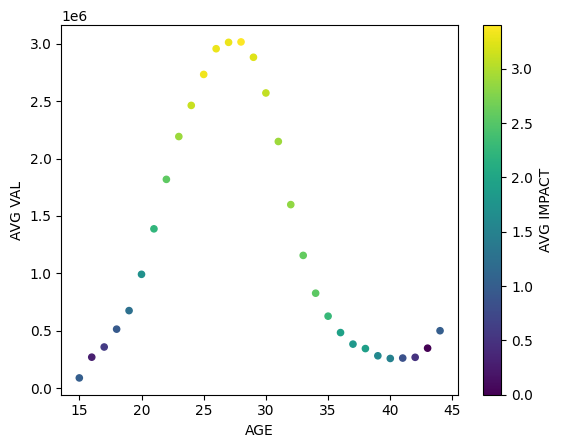

In [11]:
# SQL: Find average player valuation vs player age
query = """
WITH AGE_VAL AS (
    SELECT p.PLAYER_ID
        ,pv.DATE-p.DATE_OF_BIRTH AS AGE
        ,ROUND(AVG(pv.market_value_in_eur),2) AS AVG_VAL
    FROM PLAYERS p
    INNER JOIN PLAYER_VALUATIONS pv
    ON p.PLAYER_ID = pv.PLAYER_ID
    WHERE p.DATE_OF_BIRTH IS NOT NULL
    GROUP BY pv.DATE-p.DATE_OF_BIRTH,p.PLAYER_ID
    ORDER BY pv.DATE-p.DATE_OF_BIRTH 
), PLAYER_IMPACT AS (
    SELECT p.PLAYER_ID
        ,a.DATE - p.DATE_OF_BIRTH AS AGE
        ,SUM(a.GOALS + a.ASSISTS) AS IMPACT
    FROM PLAYERS p
    INNER JOIN APPEARANCES a
    ON p.PLAYER_ID = a.PLAYER_ID
    WHERE p.DATE_OF_BIRTH IS NOT NULL
    GROUP BY a.DATE - p.DATE_OF_BIRTH,p.PLAYER_ID
)
SELECT a.AGE
    ,ROUND(AVG(AVG_VAL),2) [AVG VAL]
    ,ROUND(AVG(IMPACT),2) [AVG IMPACT]
FROM AGE_VAL a 
LEFT JOIN PLAYER_IMPACT p
ON a.PLAYER_ID = p.PLAYER_ID
AND a.AGE = p.AGE
GROUP BY a.AGE
;
"""

df1 = pd.read_sql(query, conn)
df1.head(50)
ax1 = df1.plot.scatter(x='AGE',
                      y='AVG VAL',
                      c='AVG IMPACT'
)

In [20]:
# SQL: Find average player valuation vs player age
query = """
WITH AGE_VAL AS (
    SELECT p.PLAYER_ID
        ,pv.DATE-p.DATE_OF_BIRTH AS AGE
        ,ROUND(AVG(pv.market_value_in_eur),2) AS AVG_VAL
    FROM PLAYERS p
    INNER JOIN PLAYER_VALUATIONS pv
    ON p.PLAYER_ID = pv.PLAYER_ID
    WHERE p.DATE_OF_BIRTH IS NOT NULL
    GROUP BY pv.DATE-p.DATE_OF_BIRTH,p.PLAYER_ID
    ORDER BY pv.DATE-p.DATE_OF_BIRTH 
), PLAYER_IMPACT AS (
    SELECT p.PLAYER_ID
        ,a.DATE - p.DATE_OF_BIRTH AS AGE
        ,SUM(a.GOALS + a.ASSISTS) AS IMPACT
    FROM PLAYERS p
    INNER JOIN APPEARANCES a
    ON p.PLAYER_ID = a.PLAYER_ID
    WHERE p.DATE_OF_BIRTH IS NOT NULL
    GROUP BY a.DATE - p.DATE_OF_BIRTH,p.PLAYER_ID
)
SELECT a.AGE
    ,ROUND(AVG_VAL,2) [AVG VAL]
    ,ROUND(CASE 
        WHEN IMPACT IS NULL THEN 0
        ELSE IMPACT END,2) [AVG IMPACT]
FROM AGE_VAL a 
LEFT JOIN PLAYER_IMPACT p
ON a.PLAYER_ID = p.PLAYER_ID
AND a.AGE = p.AGE
;
"""

df1 = pd.read_sql(query, conn)
df1.head(50)
ax1 = df1.plt.subplot()
l1, = ax1.plot('AVG VAL', color = 'green')
ax2 = ax1.twinx()
l2, = ax2.plot('AVG IMPACT', color = 'blue')

plt.legend([l1,l2], ['Value','Impact'])

#ax1 = plt.subplot()
#l1, = ax1.plot(speed, color='red')
#ax2 = ax1.twinx()
#l2, = ax2.plot(acceleration, color='orange')
#
#plt.legend([l1, l2], ["speed", "acceleration"])
#
#plt.show()

AttributeError: 'DataFrame' object has no attribute 'plt'

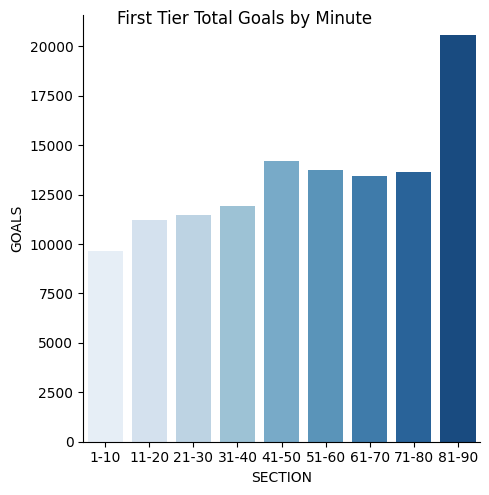

In [45]:
query ="""
SELECT --ge.MINUTE [MINUTE]
CASE 
        WHEN ge.MINUTE BETWEEN 1 AND 10 THEN '1-10'
        WHEN ge.MINUTE BETWEEN 11 AND 20 THEN '11-20'
        WHEN ge.MINUTE BETWEEN 21 AND 30 THEN '21-30'
        WHEN ge.MINUTE BETWEEN 31 AND 40 THEN '31-40'
        WHEN ge.MINUTE BETWEEN 41 AND 50 THEN '41-50'
        WHEN ge.MINUTE BETWEEN 51 AND 60 THEN '51-60'
        WHEN ge.MINUTE BETWEEN 61 AND 70 THEN '61-70'
        WHEN ge.MINUTE BETWEEN 71 AND 80 THEN '71-80'
        WHEN ge.MINUTE BETWEEN 81 AND 90 THEN '81-90'
        ELSE NULL END [SECTION]
        ,COUNT(ge.TYPE) [GOALS]
        ,ROUND(1.0 * COUNT(ge.TYPE) / 
            NULLIF((SELECT COUNT(ge.TYPE) 
                    FROM COMPETITIONS c 
                    INNER JOIN GAMES g 
                    ON c.COMPETITION_ID = g.COMPETITION_ID 
                    LEFT JOIN GAME_EVENTS ge 
                    ON g.GAME_ID = ge.GAME_ID 
                        AND ge.TYPE = 'Goals' 
                        WHERE c.TYPE = 'domestic_league'
                        --AND c.COUNTRY_NAME = 'England'
                        ),0),4) [%]
FROM COMPETITIONS c
INNER JOIN GAMES g
ON c.COMPETITION_ID = g.COMPETITION_ID
LEFT JOIN GAME_EVENTS ge
ON g.GAME_ID = ge.GAME_ID
AND ge.TYPE = 'Goals'
WHERE c.TYPE = 'domestic_league'
--AND c.COUNTRY_NAME = 'England'
GROUP BY 1
HAVING COUNT(ge.TYPE) > 0
ORDER BY 1 ASC
;
"""


df1 = pd.read_sql(query, conn)
df1.head(50)

g = sns.catplot(x='SECTION',
            y='GOALS',
            data=df1,
            kind='bar',
            palette='Blues')
g.fig.suptitle('First Tier Total Goals by Minute')
plt.show()
#sns.histplot(df1['GOALS'],kde = False, bins = 9)
